# CART Algorithm

### CART algorithm is a decision tree algorithm. The algorithm is based on the Gini coefficient and the concepts of Balance and Purity.

The algorithm tries to perform a binary split by the purity and balance levels of each node if they were to split by a predictor.
The algorithm tries to find the best predictor of each node and then splits it.
*  The algorithm stops if reaches a certain purity level in each node.

In [85]:
from sklearn import tree
from sklearn import preprocessing
import matplotlib as plt
import pandas as pd
import numpy as np
import os

base_data_path = "datasets\\"
titanic_train_path = os.path.join(base_data_path,"titanic\\train.csv")
titanic_test_path = os.path.join(base_data_path,"titanic\\test.csv")
titanic_test_results_path = os.path.join(base_data_path,"titanic\\gender_submission.csv")
print(titanic_train_path)
print(titanic_test_path)
print(titanic_test_results_path)

datasets\titanic\train.csv
datasets\titanic\test.csv
datasets\titanic\gender_submission.csv


# The DataSet

### The dataset contains data on the passangers from the titanic. The model goal is to predict who survived and who didn't their features.

* Some featues are irrelevant and were removed. If you remove more featues, the model accuracy will be better but might result in overfitting.
* You can play with the feautes to remove and see different results
* The dataset is split to train, test and test results (which called gender_submission) 
* The data needs to go through a pipeline due to sklearn library limitations:

    1.  The features can't be categorial so "Embarked" feature needs to be encoded and "Sex" feature needs to be transformed into one-hot-vector
    2. The library can't handle NaN values, so every NaN row was dropped from the dataset (makes it harder to learn)

In [81]:
def data_pipeline(data):
    # irrelavant_featues = ['PassengerId','Name','Ticket','Cabin','Pclass','Age','SibSp','Parch','Fare','Embarked']
    irrelavant_featues = ['PassengerId','Name','Ticket','Cabin']
    data = data.drop(irrelavant_featues,axis=1)
    encoder_embarked = preprocessing.LabelEncoder()
    encoder_embarked.fit(data['Embarked'])
    encoded_embarked = encoder_embarked.transform(data['Embarked'])
    data['Embarked'] = encoded_embarked
    data = pd.get_dummies(data,drop_first=True,columns=['Sex'])
    data = data.rename({"Sex_male":"Sex"},axis=1)
    print(f"Data size before drop {len(data)}")
    data = data.dropna(axis=0)
    print(f"Data size after drop {len(data)}")
    return data
train_data = pd.read_csv(titanic_train_path)
train_data = data_pipeline(train_data)
Y = train_data.pop('Survived')
train_data.head(n=len(train_data))

Data size before drop 891
Data size after drop 714


,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex
0,3,22.0,1,0,7.2500,2,1
1,1,38.0,1,0,71.2833,0,0
2,3,26.0,0,0,7.9250,2,0
3,1,35.0,1,0,53.1000,2,0
4,3,35.0,0,0,8.0500,2,1
...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,1,0
886,2,27.0,0,0,13.0000,2,1
887,1,19.0,0,0,30.0000,2,0
889,1,26.0,0,0,30.0000,0,1


# The Model

### The model is a CART model that classifies who survived on the titanic.

The model is built using sklearn.tree module, and it is a CART model since the criterion in "gini".

In [96]:
# The gini criterion makes it a CART model
cart_tree = tree.DecisionTreeClassifier(criterion='gini',max_depth=8)
cart_tree = cart_tree.fit(train_data,Y)

# Evaluation

### The model is evaluated by performing the same data pipeline process on the test set, make prediction for every row, and then counts the success.

It looks like the model didn't had very good accuracy with default parameters (74%). I have 2 assumptions:

1. The train/test ration that was given was problematic for CART algorithm
2. I lost some data due to NaN rows that were dropped
3. The model was overfitted and needs to be tuned

* After changing the max_depth to 8, it went up to 84% 

In [97]:
test_data = pd.read_csv(titanic_test_path)
test_data = data_pipeline(test_data)
test_real_values = pd.read_csv(titanic_test_results_path)
test_real_values = np.array(test_real_values['Survived'])
test_real_values = test_real_values[test_data.index]
predictions = cart_tree.predict(test_data)
results = np.array([x==y for (x,y) in zip(test_real_values,predictions)])
hits = np.count_nonzero(results==True)
print(f"accuracy = {(hits/len(results))*100}%")


Data size before drop 418
Data size after drop 331
accuracy = 84.59214501510573%


# Tree plot example

[Text(0.5, 0.8333333333333334, 'X[6] <= 0.5\ngini = 0.482\nsamples = 714\nvalue = [424, 290]'),
 Text(0.25, 0.5, 'X[0] <= 2.5\ngini = 0.37\nsamples = 261\nvalue = [64, 197]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'X[1] <= 6.5\ngini = 0.326\nsamples = 453\nvalue = [360, 93]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

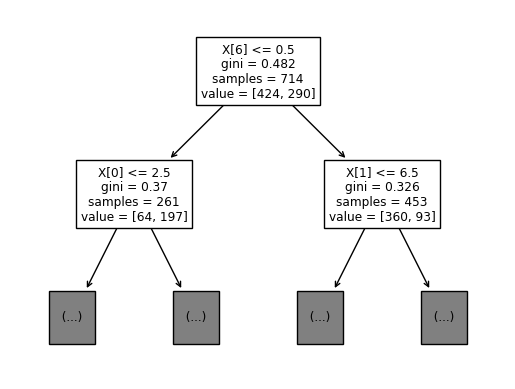

In [100]:
tree.plot_tree(cart_tree,max_depth=1)